In [1]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [2]:
def yang_zhang_vol(ohlc: pl.Expr, N: int) -> pl.Expr:
    h_c = pl.col("high").log() - pl.col("close").log()
    h_o = pl.col("high").log() - pl.col("open").log()
    l_c = pl.col("low").log() - pl.col("close").log()
    l_o = pl.col("low").log() - pl.col("open").log()
    return ((1 / N) * (h_c * h_o + l_c * l_o).rolling_sum(N)).sqrt()

In [3]:
spx = pl.read_csv("./data/SPX.csv")
spx = spx.select(
    [
        pl.col("date").str.strptime(pl.Date, format="%Y-%m-%d"),
        pl.col("close").alias("spx"),
        # Shift this 1 period forward so the value on a day doesn't use that day's information
        # in the calculation
        yang_zhang_vol(pl.col(["open", "high", "low", "close"]), 21)
        .alias("spx_real_vol")
        .shift(1)
        * np.sqrt(252)
        * 100,
    ]
)
vix = pl.read_csv("./data/VIX_History.csv")
vix = vix.select(
    [
        pl.col("date").str.strptime(pl.Date, format="%m/%d/%Y"),
        pl.col("close").alias("vix"),
    ]
)
data = spx.join(vix, on="date", how="inner")

# Daily log return
data = data.with_columns(
    [
        pl.col("spx").log().diff().alias("spx_ret"),
        pl.col("vix").log().diff().alias("vix_ret"),
    ]
)
# Return over the NEXT 21 days
data = data.with_columns(
    [
        pl.col("spx_ret").rolling_sum(21).shift(-21).alias("spx_for_ret"),
        pl.col("vix_ret").rolling_sum(21).shift(-21).alias("vix_for_ret"),
    ]
)
# VIX return in standard deviation terms
data = data.with_columns(
    (pl.col("vix_ret") / pl.col("vix_ret").rolling_std(21).shift(1)).alias(
        "vix_ret_std"
    )
)

data = data.drop_nulls()

# Correlation Between Jumps and Future VIX Returns

In [4]:
stdevs = np.linspace(0, 3, 100)
corrs = []
ps = []

for x in stdevs:
    jump_data = data.select(
        [
            pl.col("vix_for_ret"),
            pl.when(pl.col("vix_ret_std") >= x).then(1).otherwise(0).alias("jump"),
        ]
    )
    x = jump_data["jump"].to_numpy()
    y = jump_data["vix_for_ret"].to_numpy()
    result = stats.pearsonr(x, y, alternative="less")
    corrs.append(result.statistic)
    ps.append(result.pvalue)

Text(0, 0.5, 'Correlation with Future VIX Returns')

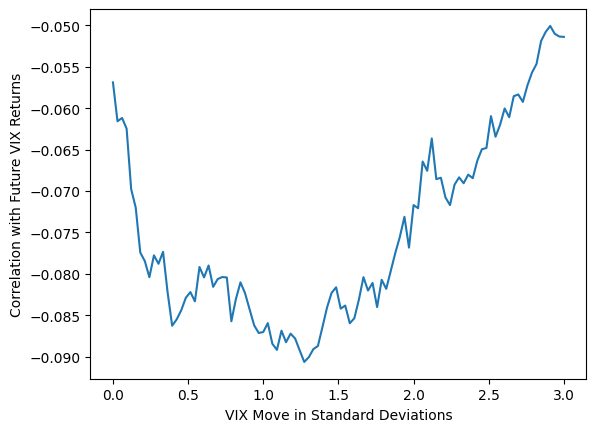

In [5]:
plt.plot(stdevs, corrs)
plt.xlabel("VIX Move in Standard Deviations")
plt.ylabel("Correlation with Future VIX Returns")

In [6]:
# At all jump cutoffs, negative correlation is extremely significant
max(ps)

2.35362891778413e-06

# Correlation Between VIX, Realized Volatility, and Future VIX Returns

In [40]:
iv_rv = data.select(
    [
        pl.col("date"),
        pl.col("vix_for_ret"),
        (pl.col("vix") - pl.col("spx_real_vol")).alias("iv_rv_gap"),
    ]
)

In [78]:
lengths = range(1, 253)
corrs = []
ps = []

for l in lengths:
    gap_data = iv_rv.with_columns(
        (pl.col("iv_rv_gap") - pl.col("iv_rv_gap").rolling_mean(l)).alias("gap_ovr_avg")
    )
    gap_data = gap_data.select(
        [
            pl.col("vix_for_ret"),
            pl.when(pl.col("gap_ovr_avg") >= 0).then(1).otherwise(0).alias("pos_gap"),
        ]
    )
    x = gap_data["pos_gap"].to_numpy()
    y = gap_data["vix_for_ret"].to_numpy()
    result = stats.pearsonr(x, y, alternative="less")
    corrs.append(result.statistic)
    ps.append(result.pvalue)

Text(0, 0.5, 'Correlation with Future VIX Returns')

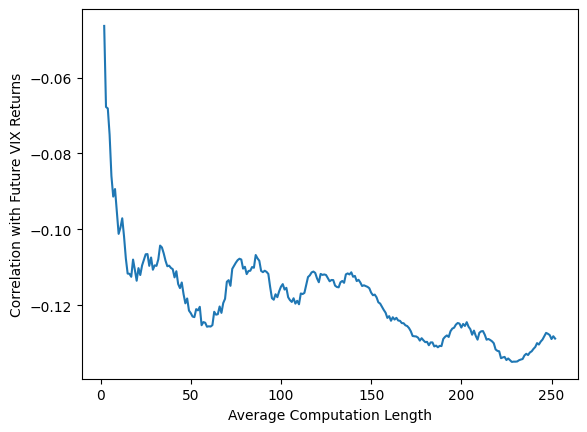

In [82]:
plt.plot(lengths, corrs)
plt.xlabel("Average Computation Length")
plt.ylabel("Correlation with Future VIX Returns")

In [89]:
cutoffs = np.linspace(0, 20, 100)
corrs = []
ps = []

for c in cutoffs:
    gap_data = iv_rv.with_columns(
        (pl.col("iv_rv_gap") - pl.col("iv_rv_gap").rolling_mean(42)).alias("gap_ovr_avg")
    )
    gap_data = gap_data.select(
        [
            pl.col("vix_for_ret"),
            pl.when(pl.col("gap_ovr_avg") >= c).then(1).otherwise(0).alias("pos_gap"),
        ]
    )
    x = gap_data["pos_gap"].to_numpy()
    y = gap_data["vix_for_ret"].to_numpy()
    result = stats.pearsonr(x, y, alternative="less")
    corrs.append(result.statistic)
    ps.append(result.pvalue)

Text(0, 0.5, 'Correlation with Future VIX Returns')

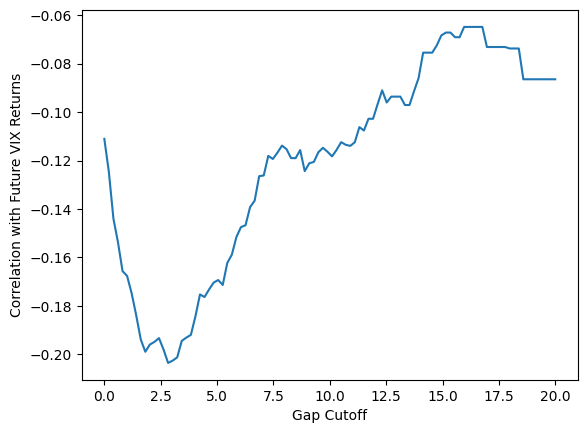

In [97]:
plt.plot(cutoffs, corrs)
plt.xlabel("Gap Cutoff")
plt.ylabel("Correlation with Future VIX Returns")